# 2CSSID Lab05. Neural Networks

<p style='text-align: right;font-style: italic;'>Designed by: Mr. Abdelkrime Aries</p>

In this lab, we will learn about neural networks (NN).
We will implement backpropagation to understand how a NN works.
Then, we will test many concepts:
- Parameters' initialization
- Activation functions effect
- Optimization functions for NN

**Team:**
- **Member 01**: ALISMAIL Dyna Hayem
- **Member 02**: AINOUCHE Melissa

In [12]:
import matplotlib
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
from matplotlib      import colors 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.26.2', '2.2.2', '3.9.2')

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
import logging, os
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow              import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, Model


In [15]:
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

## I. Algorithms implementation

In this section, we will try to implement a NN.
A network is composed of many layers, each of many neurons.


**>> Try to use "numpy" which will save a lot of time and effort** 

In [16]:
# API (Do not change, or you'll see double)
# This is just an interface to define Activation and Loss functions' behaviour

# =====================================================
# =========== Activation function API =================
# =====================================================
class Activation(object): 
    """Base Class to implement activation functions"""

    def __init__(self):
        raise Exception('This class is abstract; implement it')
      
    def activate(self, Z):
        """Calculates the activation based on Z"""
        raise Exception('Must be implemented in child class')

    def partial(self, Z, H):
        """Calculates partial derivative based on Z and the activation H"""
        raise Exception('Must be implemented in child class')

# =====================================================
# ============== Loss function API ====================
# =====================================================
class Loss(object): 
    """Base Class to implement loss functions"""

    def __init__(self):
        raise Exception('This class is abstract; implement it')

    def calculate(self, H, Y):
        """Calculates the loss based on the infered output H and the real output Y"""
        raise Exception('Must be implemented in child class')
    
    def partial(self, H, Y):
        """Calculates partial derivative based on the infered output H and the real output Y"""
        raise Exception('Must be implemented in child class')

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# This class is abstract; implement it
# This class is abstract; implement it
# works3
#---------------------------------------------------------------------

try:
    aa = Activation()
    print('works1')
except Exception as e:
    print(e)
try:
    ll = Loss()
    print('works2')
except Exception as e:
    print(e)

class ActivationChild(Activation):
    def __init__(self):
        pass
try:
    aa = ActivationChild()
    print('works3')
except Exception as e:
    print(e)

This class is abstract; implement it
This class is abstract; implement it
works3


### I.1. Activation functions

You have to implement both logistic regression and ReLU activation functions. 

Logistic regression:
$$H = \sigma(Z) = \frac{1}{1+e^{-Z}} \ \ \ \ \ \ \frac{\partial \sigma(Z)}{\partial Z} = \sigma(Z) (1-\sigma(Z))$$

ReLU:
$$H = ReLU(Z) = \begin{cases} Z & \text{if } Z > 0 \\ 0 & \text{otherwise}\end{cases}
\ \ \ \ \ \ 
\frac{\partial ReLU(Z)}{\partial Z} = \begin{cases} 1 & \text{if } Z > 0 \\ 0 & \text{otherwise}\end{cases}$$


In [17]:
# TODO: Logistic Activation class
class Logistic(Activation):
    def __init__(self):
        pass

    def activate(self, Z):
        return 1 / (1 + np.exp(-Z))

    def partial(self, Z, A):
        return A * (1 - A)


#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array([0.84104179, 0.84290453]), array([0.1336905 , 0.13241648]))
#---------------------------------------------------------------------

lg = Logistic()
z4_1       = np.array([1.666, 1.68])
a4_1       = lg.activate(z4_1)
a4_1p      = lg.partial(z4_1, a4_1)

a4_1, a4_1p

(array([0.84104179, 0.84290453]), array([0.1336905 , 0.13241648]))

In [18]:
# TODO: ReLU Activation class
class ReLU(Activation):
    def __init__(self):
        pass

    def activate(self, Z):
        return np.maximum(0, Z).astype(float)

    def partial(self, Z, A):
        return (Z > 0).astype(float)


#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array([0., 2., 0.]), array([0., 1., 0.]))
#---------------------------------------------------------------------

relu = ReLU()
z_t  = np.array([0, 2, -3])
a_t  = relu.activate(z_t)
p_t  = relu.partial(z_t, a_t)

a_t, p_t

(array([0., 2., 0.]), array([0., 1., 0.]))

### I.2. Loss functions

Binary Cross ntropy (BCE) loss function is calculated as:
$$BCE(Y, H) = - ( Y \log(H) + (1-Y) \log(1-H))$$

It's derivative is calculated as:
$$\frac{\partial BCE}{\partial H} = \frac{H-Y}{H - H^2}$$

In [19]:
# TODO: BCE Loss class
class BCE(Loss):
    def __init__(self):
        pass

    def calculate(self, H, Y):
        return -(Y * np.log(H) + (1 - Y) * np.log(1 - H))

    def partial(self, H, Y):
        return (H - Y) / (H * (1 - H))

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# (array([1.83258146, 0.17078832]), array([ 6.25      , -1.18623962]))
#---------------------------------------------------------------------

bce = BCE()

H = np.array([0.840 , 0.843])
Y = np.array([0., 1.])
J = bce.calculate(H, Y)
DJ = bce.partial(H, Y)

J, DJ

(array([1.83258146, 0.17078832]), array([ 6.25      , -1.18623962]))

### I.3. Neuron

Let us implement retropropagation of one neuron.

$$\delta^{(l)} = \frac{\partial f^{(l)}}{\partial z^{(l)}} w^{(l+1)} \delta^{(l+1)}$$

$$\frac{\partial J}{\partial w^{(l)}} = a^{(l-1)} \delta^{(l)}$$

$$\frac{\partial J}{\partial b^{(l)}} = \delta^{(l)}$$

The product is a matrix product (on $M$) and we must take the average of the outputs (on $Ln$).

The function that updates the parameters takes as input:
- $W[L_p]$ a list of weights; a vector of size $L_p$ (the number of neurons in the previous layer)
- $b$ bias
- $Z[M]$ the linear combination of the current neuron; a vector of size $M$ (the number of samples)
- $A[M]$ the activation of the current neuron; a vector of size $M$
- $A\_past[M, L_p]$ the activations of the neurons of the previous layer; a matrix of size is $(M * L_p)$
- $Delta\_next[M, Ln]$ the delta calculated in the next layer; a matrix of size $M * L_n$ ($L_n$: the number of neurons in the next layer)
- $W\_next[Ln]$ the weights to the next layer; a vector of size $Ln$
- $act$ is an "Activation" type object; it provides two methods: "act.activate" and "act.partial"
- $alpha$ the training step

In [20]:
# TODO: Neuron Backpropagation
def backpropagate_neuron(W, b, Z, A, A_past, Delta_next, W_next, act, alpha=1.):
    Delta = act.partial(Z, A) * np.dot(Delta_next, W_next)

    grad_w = np.mean(Delta.reshape(-1,1) * A_past, axis=0)
    grad_b = np.mean(Delta)

    Wn = W - alpha * grad_w
    bn = b - alpha * grad_b

    return Wn, bn, Delta

#=====================================================================
# UNIT TEST 
#=====================================================================
# Result: 
# (array([0.49375218, 0.2046736 ]),
#  -0.30324311474187016,
#  array([ 0.00696306, -0.00047683]))
#---------------------------------------------------------------------

W_t = np.array([0.5, 0.2])
b_t = -0.3
Z_t = np.array([0.5, 2.2])

# A_t[M] (This neuron's current activation)
A_t = np.array([0.62245933, 0.90024951])

# A_past_t[M, L_p] (This neuron's past layer's activations)
A_past_t = np.array([[2., -1.], [3., 5.]])

# Delta_next_t[M, L_n] (This neuron's next layer's deltas)
Delta_next_t = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T

# W_next_t[L_n] (This neuron's next layer's Weights)
W_next_t = np.array([0.3, -0.1])

act = Logistic() # Activation function

W_nouv, b_nouv, Delta_nouv = backpropagate_neuron(W_t, b_t, Z_t, A_t, A_past_t, Delta_next_t, W_next_t, act, alpha=1.)

W_nouv, b_nouv, Delta_nouv

(array([0.49375218, 0.2046736 ]),
 -0.30324311474187016,
 array([ 0.00696306, -0.00047683]))

In [21]:
# Nothing to do here 
class Neuron(object):
    def __init__(self, in_size, activation=Logistic()):
        self.b   = 0.
        self.w   = np.array([0.] * in_size)
        self.act = activation
        
    def randomize(self):
        self.w = np.random.rand(len(self.w))
        self.b = np.random.rand(1)[0]
        
    def __aggregate(self, X):
        return np.dot(X, self.w) + self.b
    
    def activate(self, X):
        self.a_past = X
        self.z      = self.__aggregate(X)
        self.a      = self.act.activate(self.z)
        return self.a
    
    def update(self, delta_next, w_next, alpha=1.):
        w_past                = self.w.copy()
        self.w, self.b, delta = backpropagate_neuron(self.w, self.b, self.z, self.a, self.a_past, delta_next, w_next, self.act, alpha=alpha)
        return delta, w_past

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# z2_1 = [0.5 2.2]
# a2_1 = [0.62245933 0.90024951]
# partial(a2_1) = [0.23500371 0.08980033]
# past b = -0.3
# past w = [0.5 0.2]
# delta2 = [ 0.00696306 -0.00047683]
# new b = -0.30324311473938026
# new w = [0.49375218 0.2046736 ]
#---------------------------------------------------------------------

# New neuron with two inputs
n = Neuron(2)
# ---------------------
# We should not affect the weights directly
# Here, it's just to have the same weights of the output neuron in the example seen in the lecture
# We will reproduce the parameters of neuron 1 hidden layer 1 (layer 2)
n.b = -0.3
n.w = np.array([0.5, 0.2])
# ---------------------

# M X Lp (Here A1 = X; the input)
A1 = np.array([[2., -1.], [3., 5.]])
# M X Ln (Delta of the next layer)
Delta3 = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
W3_1 = np.array([0.3, -0.1])


A2_1 = n.activate(A1)
print("z2_1 = " + str(n.z))
print("a2_1 = " + str(A2_1))
# The partial derivative of logistic function does not need Z, so we pass 0 (to not calculte it)
print("partial(a2_1) = " + str(n.act.partial(0, A2_1)))
print("past b = " + str(n.b))

Delta2, W2_past = n.update(Delta3, W3_1) 

print("past w = " + str(W2_past))
print("delta2 = " + str(Delta2))
print("new b = " + str(n.b))
print("new w = " + str(n.w))

z2_1 = [0.5 2.2]
a2_1 = [0.62245933 0.90024951]
partial(a2_1) = [0.23500371 0.08980033]
past b = -0.3
past w = [0.5 0.2]
delta2 = [ 0.00696306 -0.00047683]
new b = -0.30324311473938026
new w = [0.49375218 0.2046736 ]


### I.4. Layer

A layer is a list of neurons.
In this case, the packpropagation of the layer takes:
- **neurons**: a list of activated neurons.
- **Delta_next**: Delta from the next layer.
- **W_next**: next layer's weights
- **alpha**: learning rate

The function returns a tuple:
- Deltas of the current layer (all neurons)
- Past weights of the current layer (all neurons)

In [22]:
# TODO: Layer Backpropagation
def backpropagate_layer(neurons, Delta_next, W_next, alpha=1.):
    W_pasts = []
    Deltas = []

    for i, neuron in enumerate(neurons):
        delta, W_update = neuron.update(Delta_next, W_next[i], alpha=alpha)

        W_pasts.append(W_update)
        Deltas.append(delta)

    return np.array(Deltas).T, np.array(W_pasts).T

#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# deltas : [[ 0.00696306  0.00682726]
#  [-0.00047683 -0.00017109]]
# past W : [[ 0.00696306  0.00682726]
#  [-0.00047683 -0.00017109]]
#---------------------------------------------------------------------


neurons_t = [Neuron(2), Neuron(2)]

# We should not directly assign  weights 
# Here, it is just to have the same weights of the output neuron of the lecture's example
neurons_t[0].b = -0.3
neurons_t[0].w = np.array([0.5, 0.2])
neurons_t[1].b = 0.5
neurons_t[1].w = np.array([0.3, 0.4])

delta3 = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
w3 = np.array([[0.3, -0.1],[0.5, -0.3]])

a1 = np.array([[2., -1.], [3., 5.]])
neurons_t[0].activate(a1)
neurons_t[1].activate(a1)

Deltas2, W_pasts2 = backpropagate_layer(neurons_t, delta3, w3)

print("deltas : " + str(Deltas2))
print("past W : " + str(Deltas2))

deltas : [[ 0.00696306  0.00682726]
 [-0.00047683 -0.00017109]]
past W : [[ 0.00696306  0.00682726]
 [-0.00047683 -0.00017109]]


In [23]:
# Do not edit
class Layer(object):
    
    def __init__(self, size, in_size, activation=Logistic()):
        self.neurons = [Neuron(in_size, activation=activation) for i in range(size)]
        
    def randomize(self):
        for neuron in self.neurons:
            neuron.randomize()

    def forward(self, X):
        activations = []
        for neuron in self.neurons:
            activations.append(neuron.activate(X))
        return np.array(activations).T
    
    def backward(self, Delta_next, W_next, alpha=1.):
        return backpropagate_layer(self.neurons, Delta_next, W_next, alpha=alpha)



#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# Activations: [[0.62245933 0.66818777]
#  [0.90024951 0.96770454]]
# Deltas: [[ 0.00696306  0.00682726]
#  [-0.00047683 -0.00017109]]
#---------------------------------------------------------------------

# layer 2 (2 neurons, 2 inputs)
c2 = Layer(2, 2)

# We should not directly assign  weights 
# Here, it is just to have the same weights of the output neuron of the lecture's example
c2.neurons[0].b = -0.3
c2.neurons[0].w = np.array([0.5, 0.2])
c2.neurons[1].b = 0.5
c2.neurons[1].w = np.array([0.3, 0.4])

delta3 = np.array([[ 0.14523862, -0.02613822], [ 0.1394202, -0.02531591]]).T
w3 = np.array([[0.3, -0.1],[0.5, -0.3]])

a1 = np.array([[2., -1.], [3., 5.]])
a2 = c2.forward(a1)
print("Activations: " + str(a2))

Deltas2, W_pasts2 = c2.backward(delta3, w3)

print("Deltas: " + str(Deltas2))

Activations: [[0.62245933 0.66818777]
 [0.90024951 0.96770454]]
Deltas: [[ 0.00696306  0.00682726]
 [-0.00047683 -0.00017109]]


### I.5. Network

A network is composed of a list of layers.
Here, we want to implement backpropagation over layers (from the last one into the first)


For the last layer:
- w_past is a list of ones of the this layer's size. Such as [[1.], [1.], ...]
- delta_past is the gradient of the loss function "J_prime" which must be calculated using the cost function, the output H and the real output Y

Then, each layer apply a backpropagation and returns delta_past, w_past which will be fed into the previous layer.

The function must return the cost J which is the average of all losses

In [24]:
# TODO: Network Backpropagation
def backpropagate_network(layers, cost, H, Y):
    w_past = np.ones((layers[-1].neurons[0].w.shape[0], 1))
    delta_past = cost.partial(H, Y)
    
    for layer in reversed(layers):
        delta_past, w_past = layer.backward(delta_past, w_past)
    
    return np.mean(cost.calculate(H, Y))


#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# w4_1 = [0.51494626 0.56592079]
# w3_1 = [0.2665629 0.4641237]
# w3_2 = [-0.13199638 -0.33433028]
# w2_1 = [0.49375219 0.2046736 ]
# w2_2 = [0.29342937 0.40384135]
# 1.0020916974430965
#---------------------------------------------------------------------

X = np.array([[2., -1.], [3., 5.]])
Y = np.array([[0.], [1.]])

layers = [ Layer(2, 2), Layer(2, 2), Layer(1, 2) ]

# We should not directly assign  weights 
# Here, it is just to have the same weights of the output neuron of the lecture's example
layers[0].neurons[0].b = -0.3
layers[0].neurons[0].w = np.array([0.5, 0.2])
layers[0].neurons[1].b = 0.5
layers[0].neurons[1].w = np.array([0.3, 0.4])

layers[1].neurons[0].b = -0.3
layers[1].neurons[0].w = np.array([0.3, 0.5])
layers[1].neurons[1].b = -0.2
layers[1].neurons[1].w = np.array([-0.1, -0.3])

layers[2].neurons[0].b = 1.
layers[2].neurons[0].w = np.array([0.7, 0.7])

H = X
for layer in layers:
    H = layer.forward(H)

J = backpropagate_network(layers, bce, H, Y)

print("w4_1 = " + str(layers[2].neurons[0].w))
print("w3_1 = " + str(layers[1].neurons[0].w))
print("w3_2 = " + str(layers[1].neurons[1].w))
print("w2_1 = " + str(layers[0].neurons[0].w))
print("w2_2 = " + str(layers[0].neurons[1].w))

J


w4_1 = [0.51494626 0.56592079]
w3_1 = [0.2665629 0.4641237]
w3_2 = [-0.13199638 -0.33433028]
w2_1 = [0.49375219 0.2046736 ]
w2_2 = [0.29342937 0.40384135]


1.0020916974430965

In [25]:
# Do not change
class NN(object):
    def __init__(self, in_size, cost=bce, alpha=1.):
        self.current_size = in_size # the last layer's size 
        self.cost = cost
        self.alpha = alpha
        self.layers = []

    def add_layer(self, size, activation=Logistic()):
        new_layer = Layer(size, self.current_size, activation=activation)
        self.layers.append(new_layer)
        self.current_size = size
        
    def randomize(self):
        for layer in self.layers:
            layer.randomize()
    
    def predict(self, X): 
        Y = X
        if self.norm:
            Y = np.where(self.std==0, X, (X - self.mean)/self.std)
            
        for layer in self.layers:
            Y = layer.forward(Y)
        if Y.ndim == 2 and Y.shape[1] == 1:
            Y = Y.flatten()
        return np.where(Y < 0.5, 0, 1)
    
    
    def _one_iteration(self, X, Y):
        # forward propagation
        a = X
        for layer in self.layers:
            a = layer.forward(a)
            
        # cost and its derivative calculation
        YY = np.array(Y)
        if YY.ndim < 2 : 
            YY = YY[:, np.newaxis]
        
        # backward propagation 
        J = backpropagate_network(self.layers, self.cost, a, YY)
    
        return J
    
    def fit(self, X, Y, nbr_it=100, norm=False):
        costs = []
        X_norm = X
        self.norm = norm
        if norm:
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
            X_norm = np.where(self.std==0, X, (X - self.mean)/self.std)

        for i in range(nbr_it): 
            J = self._one_iteration(X_norm, Y)
            costs.append(J)
        return costs
    
#=====================================================================
# UNIT TEST
#=====================================================================
# Result: 
# cost = 1.0020916974430965
# w4_1 = [0.51494626 0.56592079]
# w3_1 = [0.2665629 0.4641237]
# w3_2 = [-0.13199638 -0.33433028]
# w2_1 = [0.49375219 0.2046736 ]
# w2_2 = [0.29342937 0.40384135]
# Prediction: [0 1]
#---------------------------------------------------------------------

X = np.array([[2., -1.], [3., 5.]])
Y = np.array([0., 1.])

nn = NN(2) # 2 features
nn.add_layer(2) # add a hidden layer with 2 neurons
nn.add_layer(2) # add a hidden layer with 2 neurons
nn.add_layer(1) # add an output layer with 1 neuron

# We should not affect the weights directly
# Here, it's just to have the same weights of the output neuron in the example seen in the lecture
nn.layers[0].neurons[0].b = -0.3
nn.layers[0].neurons[0].w = np.array([0.5, 0.2])
nn.layers[0].neurons[1].b = 0.5
nn.layers[0].neurons[1].w = np.array([0.3, 0.4])

nn.layers[1].neurons[0].b = -0.3
nn.layers[1].neurons[0].w = np.array([0.3, 0.5])
nn.layers[1].neurons[1].b = -0.2
nn.layers[1].neurons[1].w = np.array([-0.1, -0.3])

nn.layers[2].neurons[0].b = 1.
nn.layers[2].neurons[0].w = np.array([0.7, 0.7])

J = nn._one_iteration(X, Y)

print("cost = " + str(J))
print("w4_1 = " + str(nn.layers[2].neurons[0].w))
print("w3_1 = " + str(nn.layers[1].neurons[0].w))
print("w3_2 = " + str(nn.layers[1].neurons[1].w))
print("w2_1 = " + str(nn.layers[0].neurons[0].w))
print("w2_2 = " + str(nn.layers[0].neurons[1].w))

nn.fit(X, Y, nbr_it=200)
print("Prediction: " + str(nn.predict(X)))


cost = 1.0020916974430965
w4_1 = [0.51494626 0.56592079]
w3_1 = [0.2665629 0.4641237]
w3_2 = [-0.13199638 -0.33433028]
w2_1 = [0.49375219 0.2046736 ]
w2_2 = [0.29342937 0.40384135]
Prediction: [0 1]


## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it.
To do this, we will use a light version of diabetes dataset.

In [26]:
# diabetes2
diabetes   = pd.read_csv("data/diabetes2.csv") 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:,  -1].values

# This configuration is on purpose
# to test the case where regression is disfavored
NBR_TEST   = 240
# Assuming the first 30% rows are for testing and the rest for training
X_test     = X_diabetes[-NBR_TEST:, :] # 30% or more
Y_test     = Y_diabetes[-NBR_TEST:   ].reshape([-1, 1])

X_train    = X_diabetes[:-NBR_TEST, :] 
Y_train    = Y_diabetes[:-NBR_TEST   ].reshape([-1, 1])

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [27]:
scaler   = StandardScaler()
X_trains = scaler.fit_transform(X_train)
X_tests  = scaler.transform(X_test)

X_trains[:5, :]

array([[ 0.63564802,  0.83833016,  0.16863427,  0.93506705, -0.67560188,
         0.22006711,  0.42947843,  1.43582544],
       [-0.85203884, -1.09137813, -0.14214721,  0.55085273, -0.67560188,
        -0.63225191, -0.38057337, -0.18535642],
       [ 1.23072277,  1.91039032, -0.24574104, -1.30618316, -0.67560188,
        -1.03405944,  0.56155209, -0.10003106],
       [-0.85203884, -0.96885697, -0.14214721,  0.16663841,  0.12145706,
        -0.44961212, -0.92060791, -1.03861003],
       [-1.14957621,  0.50139697, -1.48886696,  0.93506705,  0.74892899,
         1.37678577,  5.30446409, -0.0147057 ]])

#### II.1. Initial parameters and complexity

We want to test the benefit of parameters (thetas) initialization and the complexity of the model.
To do this, five models were trained in order to recover the training and validation errors. 
The tested models are:
- **Log0**: A single neuron (logistic regression) with initialization 0
- **LogR**: A single neuron (logistic regression) with random initialization
- **NN0**: A 4(relu)X2(relu)X1(sigmoid) neural network with initialization 0
- **NN1**: A 4(relu)X2(relu)X1(sigmoid) neural network with initialization 1
- **NNR**: A 4(relu)X2(relu)X1(sigmoid) neural network with random initialization

Log0 : Training ...
LogR : Training ...
NN0 : Training ...
NN1 : Training ...
NNR : Training ...


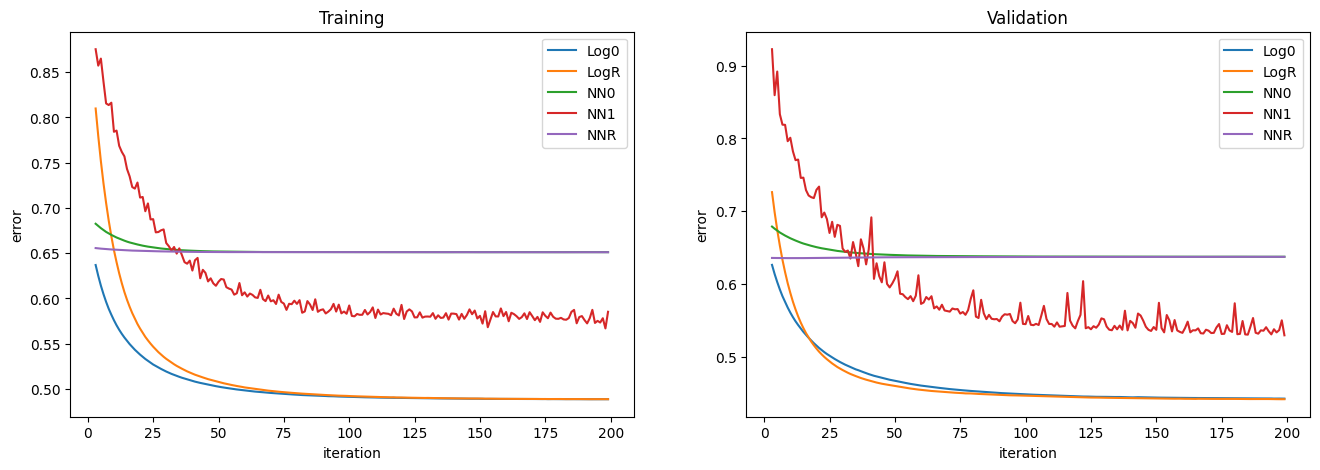

In [28]:
alpha  = 0.01
NBR_IT = 200

M, N = X_train.shape

# ==================================
# Définition des modèles
# ==================================

models = {}

models['Log0'] = Sequential()
models['Log0'].add(Dense(1, activation="sigmoid", kernel_initializer='zero', bias_initializer='zeros'))

models['LogR'] = Sequential()
models['LogR'].add(Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))

models['NN0']  = Sequential()
models['NN0'].add(Dense(4, activation="relu", kernel_initializer='zero', bias_initializer='zeros'))
models['NN0'].add(Dense(2, activation="relu", kernel_initializer='zero', bias_initializer='zeros'))
models['NN0'].add(Dense(1, activation="sigmoid", kernel_initializer='zero', bias_initializer='zeros'))

models['NN1']  = Sequential()
models['NN1'].add(Dense(4, activation="relu", kernel_initializer='one', bias_initializer='one'))
models['NN1'].add(Dense(2, activation="relu", kernel_initializer='one', bias_initializer='one'))
models['NN1'].add(Dense(1, activation="sigmoid", kernel_initializer='one', bias_initializer='one'))

models['NNR']  = Sequential()
models['NNR'].add(Dense(4, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
models['NNR'].add(Dense(2, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
models['NNR'].add(Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))

# ====================================
# Model training
# ====================================

# we do not display the first 3 iterations, until the model stabilizes
# otherwise, one model may have great value compared to others 
# therefore, we cannot visualize the convergence of the others
IT_range = range(NBR_IT)[3:]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))


for name, model in models.items():
    model.compile(loss      = tf.keras.losses.binary_crossentropy,
                 optimizer = tf.keras.optimizers.SGD(learning_rate=alpha))
    print(name, ': Training ...')
    results = model.fit(X_trains, Y_train, epochs=NBR_IT, validation_data=(X_tests, Y_test), verbose=0)
    
    # ===========================
    # PREPARATION OF THE PLOT
    # ===========================
    ax1.plot(IT_range, results.history["loss"    ][3:], label=name)
    ax2.plot(IT_range, results.history["val_loss"][3:], label=name)

# ==================================
# PLOT 
# ==================================

ax1.title.set_text("Training")
ax2.title.set_text("Validation")

ax1.set(xlabel='iteration', ylabel='error')
ax2.set(xlabel='iteration', ylabel='error')

ax1.legend()
ax2.legend()
plt.show()

**TODO: Analyze the results**

1. We notice that single-neuron models are faster than neural network models (in terms of iterations and in terms of time). Why?
1. We notice that **NN0** does not improve (it stagnates from the first iterations). Explain why.
1. We notice that **NN1** improves compared to **NN0**, but it quickly stagnates compared to **NNR**. Explain why.
1. Based on validation, what is the relationship between the number of layers, the complexity of the problem, the number/quality of data and the learning problems (under/over). Mention 4 combinations that may cause problems.

**Answers**

1. Models with a single neuron train faster than more complex neural networks because they require fewer computations (fewer weights and biases to adjust). This simplicity leads to reduced calculations and faster convergence. Additionally, the forward and backward passes for single neurons are simple.
1. When all weights and biases are initialized to zero (the case of NN0), all gradients become zero during backpropagation, which prevents the weights from being updated. As a result, the error does not improve over iterations.
1. Weights initialized to a fixed value 1: This model performs better than RN0 because the weights are not zero, avoiding the gradient vanishing issue.
Limitation: When all weights in a layer are initialized to the same value, the neurons in that layer produce the same outputs and gradients (they start with the same high activation values). This leads to redundancy and slower convergence as the gradients remain small and updates are less effective when the neurons learn in the same way, which limits the overall learning capacity of the model. In contrast, NNR uses random initialization, which introduces diversity in weights, enabling the network to learn effectively and converge better.
1. Relationship between layers, data complexity, and learning problems (4 combinations):
- **Underfitting combinations**:
   - A complex problem + A simple model (fewer layer): The model is too simple to capture the complexity of the data.
   - A simple model (fewer layer) + Insufficient or low-quality training data: The model cannot find meaningful patterns due to inadequate data or poor-quality data.
- **Overfitting combinations**:
   - A simple problem + A complex model (many layer): The model memorizes the training data, including noise, instead of generalizing.
   - A complex model (many layer) + Insufficient training data: The model overfits by memorizing the limited data, failing to generalize to new data.

#### II.2. Activation functions

We want to test which activation functions are more appropriate for the hidden layers and which ones for the output layer.
To do this, five models were trained in order to recover the history of the training error. 
The tested models are:
- **relu->sigm**: a network with **relu** in the hidden layers and **sigmoid** in the output layer
- **sigm->sigm**: a network with **sigmoid** in the hidden layers and **sigmoid** in the output layer
- **tanh->sigm**: a network with **tanh** in the hidden layers and **sigmoid** in the output layer
- **sigm->relu**: a network with **sigmoid** in the hidden layers and **relu** in the output layer
- **relu->relu**: a network with **relu** in the hidden layers and **relu** in the output layer

relu->sigm : Training ...
sigm->sigm : Training ...
tanh->sigm : Training ...
sigm->relu : Training ...
relu->relu : Training ...


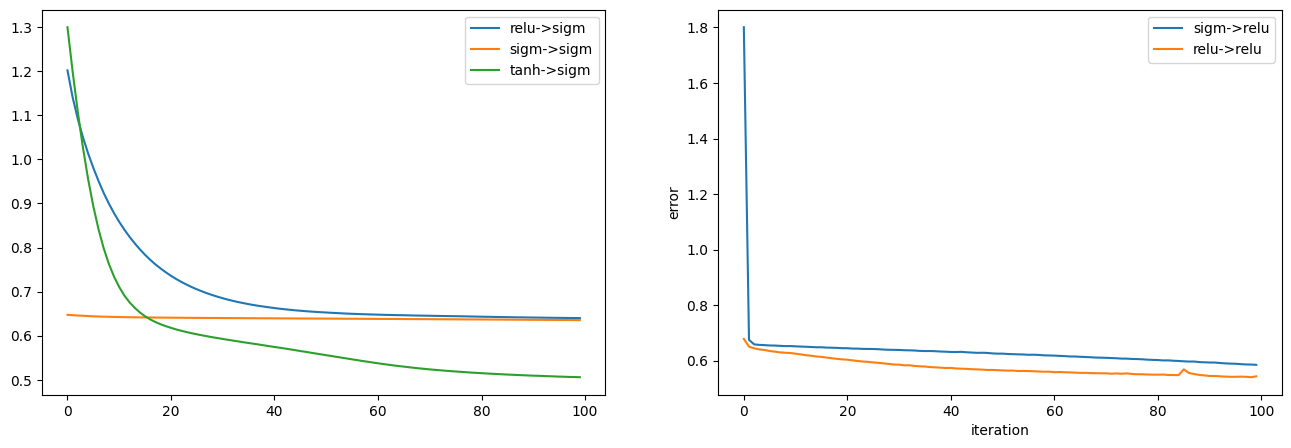

In [29]:
alpha  = 0.01
NBR_IT = 100

M, N = X_train.shape

L1 = 2 # Number of neurons in layer 1
L2 = 2 # Number of neurons in layer 2

# ==================================
# Models' design
# ==================================

defs = [ 
    ('relu->sigm', 'relu', 'sigmoid'),
    ('sigm->sigm', 'sigmoid', 'sigmoid'),
    ('tanh->sigm', 'tanh', 'sigmoid'),
    ('sigm->relu', 'sigmoid', 'relu'),
    ('relu->relu', 'relu', 'relu')
]

models = {}
params = {'kernel_initializer':'glorot_uniform', 'bias_initializer':'glorot_uniform'}

for name, in_act, out_act in defs:
    models[name] = Sequential()
    models[name].add(Dense(L1, activation = in_act , **params))
    models[name].add(Dense(L2, activation = in_act , **params))
    models[name].add(Dense(1,  activation = out_act, **params))

# ==================================
# Models' training
# ==================================

results = {}

for name, model in models.items():
    model.compile(loss      = tf.keras.losses.binary_crossentropy,
                  optimizer = tf.keras.optimizers.SGD(learning_rate=alpha))
    print(name, ': Training ...')
    results[name] = model.fit(X_trains, Y_train, epochs=NBR_IT, verbose=0)
    

# ==================================
# Plot 
# ==================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

for nom, result in results.items():
    ax = ax1 if nom.endswith('sigm') else ax2
    ax.plot(range(NBR_IT), result.history['loss'], label=nom)
    
ax1.legend()
ax2.legend()
plt.xlabel("iteration")
plt.ylabel("error")
plt.legend()
plt.show()

**TODO: Analyze the results**

1. We notice that the **sigmoid->sigmoid** model stagnated quickly. Explain how?
1. We notice that this model converged more quickly (in terms of number of iterations) compared to the two models with **sigmoid** output. Why?
1. We notice that the models with **relu** output are not stable; at each execution, we will have a different diagram (sometimes improvement, sometimes deterioration, etc.). It should be noted that random initialization is not the source of the problem since there are other similar but stable models. So why did they behave like this?

**Answers**

1. The sigmoid->sigmoid model stagnates due to the vanishing gradient problem, a phenomenon where the gradient becomes very small in deeper layers during backpropagation. The sigmoid activation function maps inputs to a range between 0 and 1, and its gradient lies between 0 and 0.25.
In deeper layers, gradients are multiplied as they propagate backward. Since sigmoid gradients are small, this multiplication leads to extremely small values, effectively "vanishing" the gradient. So, the weights in earlier layers are not updated effectively, and the model's performance stagnates without meaningful learning.
1. While the sigmoid->sigmoid model struggles with deeper layers due to vanishing gradients, its convergence speed in this specific scenario can be attributed to problems with binary classification, sigmoid activations in the output layer are appropriate because the target outputs (0 or 1) match the sigmoid range. However, models using non-sigmoid activations in hidden layers (ReLU or tanh) avoid the vanishing gradient problem and thus enable better learning. Sigmoid hidden layers converge faster in shallow architectures because their small gradient values limit weight updates, stabilizing learning. However, in deeper architectures, this causes stagnation.
1. ReLU can output very large values, especially in deeper layers, leading to highly variable weight updates during training. Also, ReLU is not differentiable at 0, and it causes died neurons for negative inputs. Additionally, since the outputs are unbounded on the positive side ([0, +∞]), (as with sigmoid or tanh), the ReLU output layer can amplify small differences in initialization, learning rate, or data noise, leading to unpredictable behaviors.

#### II.3. Optimisation functions

We want to test different optimization functions.
To do this, four models were trained in order to recover the history of the training error. 
The tested models are:
- **GD**: a network trained with gradient descent
- **Adagrad**: a network trained with AdaGrad
- **RMSprop**: a network trained with RMSprop
- **Adam**: a network trained with Adam

GD : Training ...
Adagrad : Training ...
RMSprop : Training ...
Adam : Training ...


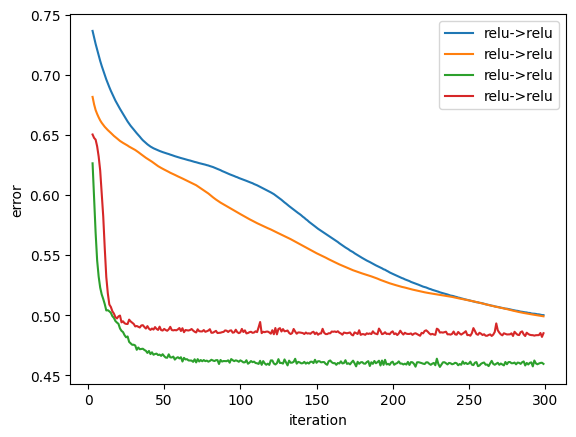

In [30]:
alpha  = 0.01
NBR_IT = 300

M, N = X_train.shape

L1 = 2
L2 = 2

# we do not display the first 3 iterations, until the model stabilizes
# otherwise, one model may have great value compared to others 
# therefore, we cannot visualize the convergence of the others
IT_range = range(NBR_IT)[3:]

defs = [ # Definitions
    ('GD'     , tf.keras.optimizers.SGD    (learning_rate=alpha)),
    ('Adagrad', tf.keras.optimizers.Adagrad(learning_rate=alpha)),
    ('RMSprop', tf.keras.optimizers.RMSprop(learning_rate=alpha)),
    ('Adam'   , tf.keras.optimizers.Adam   (learning_rate=alpha))
]

params = {'kernel_initializer':'glorot_uniform', 'bias_initializer':'glorot_uniform'}

for name, opt in defs:
    model = Sequential()
    model.add(Dense(L1, activation="relu"   , **params))
    model.add(Dense(L2, activation="relu"   , **params))
    model.add(Dense(1,  activation="sigmoid", **params))
    model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = opt)
    
    print(name, ': Training ...')
    results = model.fit(X_trains, Y_train, epochs=NBR_IT, verbose=0)
    plt.plot(IT_range, results.history["loss"][3:], label=nom)


plt.xlabel("iteration")
plt.ylabel("error")
plt.legend()
plt.show()

**TODO: Analyze the results**

1. We notice that the **GD** model converges faster than **AdaGrad**. Why?
1. Why does **RMSprop** converge faster than **AdaGrad**, yet their equations are almost similar? (here you have to explain the contribution in the equation of the first compared to the second)
1. By running this code several times, we notice that Adam is more stable. Why?

**Answers**

1. Gradient Descent (GD) converges faster than AdaGrad in this scenario due to the way each algorithm handles the learning rate: GD applies a consistent learning rate throughout training, enabling steady progress toward the minimum. AdaGrad, on the other hand, adapts the learning rate for each parameter based on the cumulative sum of squared gradients. As the training progresses, the accumulated squared gradients grow, causing the effective learning rate to become very small, leading to slow convergence or stagnation.
1. Both RMSprop and AdaGrad adapt learning rate using historical gradient information, but their difference lies in how this information is used:
    - AdaGrad: Accumulates the squared gradients of each parameter over all iterations. This accumulation is unbounded, leading to diminishing learning rates that can slow convergence or stop learning entirely.
    - RMSprop: Introduces an exponential decay factor (β) to the gradient accumulation. Instead of summing all squared gradients, RMSprop uses a moving average of recent squared gradients. This prevents the learning rate from shrinking excessively, allowing it to adapt dynamically to recent gradient changes. By giving more weight to recent gradients and less to earlier ones, RMSprop avoids AdaGrad’s problem of overly small learning rates, enabling faster and more stable convergence.
1. Adam (Adaptive Moment Estimation) combines the advantages of RMSprop and momentum. Adam uses estimates of both the first moment (mean) and the second moment (variance) of gradients. This enables it to adjust learning rates dynamically. Also, Adam applies bias correction to the moment estimates, ensuring they are unbiased during the initial iterations when data is sparse. By combining these techniques, Adam is less sensitive to initialization and hyperparameters, leading to more consistent and stable performance across multiple executions.

In [31]:
print('Good luck')

Good luck
